## 1. Import libraries

In [29]:
!pip install timm -q

In [30]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

## 2. Read dataset

In [31]:
train_data = []
train_set_path = '/kaggle/input/vqadattrans/vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [32]:
val_data = []
val_set_path = '/kaggle/input/vqadattrans/vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [33]:
test_data = []
test_set_path = '/kaggle/input/vqadattrans/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

In [34]:
classes = set([sample['answer'] for sample in train_data])
classes_to_idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx_to_classes = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx_to_classes)

{0: 'yes', 1: 'no'}


## 3. Create Pytorch dataset

In [36]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        root_dir='/kaggle/input/vqadattrans/val2014-resised/val2014-resised'
    ):
        self.data = data
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')
        
        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}
            
        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question, 
                padding="max_length", 
                max_length=20, 
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}


        label = self.data[index]['answer']
        label = torch.tensor(
            classes_to_idx[label],
            dtype=torch.long
        ).to(device)
            
        sample = {
            'image': img,
            'question': question,
            'label': label
        }
            
        return sample

In [37]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

In [38]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

# 5. Create Model

In [39]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")
        
    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [40]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [41]:
class Classifier(nn.Module):
    def __init__(
        self, 
        input_size=768*2, 
        hidden_size=512,
        n_layers=1,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier,self).__init__()
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size*2, n_classes)
        
    def forward(self,x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [25]:
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier
        

    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)
        x = torch.cat((text_out, image_out), dim=1)
        x = self.classifier(x)

        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [42]:
n_classes = len(classes)
hidden_size = 1024
n_layers = 1
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 6. Training

In [43]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [45]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [46]:
lr = 1e-4
epochs = 100
scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [47]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 0.6941	Val loss: 0.6870	Val Acc: 0.545594262295082
EPOCH 2:	Train loss: 0.6874	Val loss: 0.6867	Val Acc: 0.5461065573770492
EPOCH 3:	Train loss: 0.6842	Val loss: 0.6831	Val Acc: 0.5573770491803278
EPOCH 4:	Train loss: 0.6791	Val loss: 0.6802	Val Acc: 0.579405737704918
EPOCH 5:	Train loss: 0.6745	Val loss: 0.6786	Val Acc: 0.5814549180327869
EPOCH 6:	Train loss: 0.6718	Val loss: 0.6780	Val Acc: 0.5799180327868853
EPOCH 7:	Train loss: 0.6689	Val loss: 0.6843	Val Acc: 0.5558401639344263
EPOCH 8:	Train loss: 0.6660	Val loss: 0.6743	Val Acc: 0.5860655737704918
EPOCH 9:	Train loss: 0.6622	Val loss: 0.6713	Val Acc: 0.59375
EPOCH 10:	Train loss: 0.6591	Val loss: 0.6696	Val Acc: 0.5860655737704918
EPOCH 11:	Train loss: 0.6539	Val loss: 0.6715	Val Acc: 0.5911885245901639
EPOCH 12:	Train loss: 0.6522	Val loss: 0.6677	Val Acc: 0.59375
EPOCH 13:	Train loss: 0.6480	Val loss: 0.6655	Val Acc: 0.5988729508196722
EPOCH 14:	Train loss: 0.6459	Val loss: 0.6752	Val Acc: 0.58350409836065

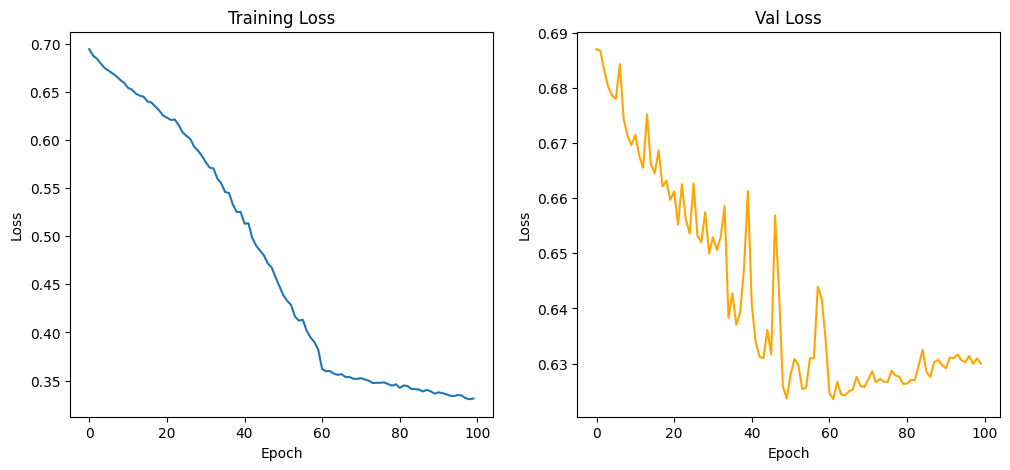

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## 7. Evaluation

In [50]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6777663934426229
Test accuracy:  0.6800197823936697
